# Demo:  House Price Feature Selection with LASSO 

In this demo, we illustrate the classic technique of LASSO regularization as a feature selection method.
You will learn to:

* Identify and one-hot code categorical variables
* Scale data before processing
* Fit a LASSO model 
* Determine the regularization level with cross-validation
* Draw the coefficient path as a function of the regularization level

The data for this demo comes from this excellent 
[Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) on predicting
housing prices.  The data was developed by Dean DeCock at Truman State University in the nice 
[paper](http://jse.amstat.org/v19n3/decock.pdf).

There is another demo in this repository on the Prostate cancer dataset that was used in earlier versions
of this class.  But, this dataset somewhat better illustrates the need for feature selection.

First, we load the regular packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


## Downloading and Cleaning the Data

On the Kaggle competition site, you can download a train data set (with labels) and a test data set (with no labels).  Here, we will just use the train dataset since it has labels that we can use to assess the results.  Later, we will split that dataset into training and test. 

In [57]:
fn_src = 'https://raw.githubusercontent.com/sdrangan/introml/master/unit05_lasso/housing_train.csv'
fn_dst = 'housing_train.csv'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:
    urllib.request.urlretrieve(fn_src, fn_dst)

File housing_train.csv is already downloaded


We then load the file into a pandas dataframe and display the data.  

In [2]:
df = pd.read_csv('housing_train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We print the number of attributes and samples.  We see that there are a large number of attributes for each home sale.

In [3]:
nsamp, natt = df.shape
print('Number samples = %d' % nsamp)
print('Number attributes per sample = %d' % natt)

Number samples = 1460
Number attributes per sample = 81


Before we proceed, we need to remove the columns with missing values. We see that we remove about 19 attributes.

In [4]:
df = df.dropna(axis=1) #drop columns with at least one missing value (not the best idea but simplest)

nsamp, natt = df.shape
print('Number samples = %d' % nsamp)
print('Number attributes per sample = %d' % natt)


Number samples = 1460
Number attributes per sample = 62


It is suggested in DeCock's [paper](http://jse.amstat.org/v19n3/decock.pdf), that to make the regression easier, we remove all the entries where the `SaleCondition` was not normal.  We do this with the following code which should leave us with 1198 samples.

In [5]:
df = df.loc[df['SaleCondition'] == 'Normal']

nsamp, natt = df.shape
print('Number samples = %d' % nsamp)
print('Number attributes per sample = %d' % natt)

Number samples = 1198
Number attributes per sample = 62


## One-Hot Coding the Categorical Variables

You will see there are a large number of variables that are *categorical* meaning they are one of a few discrete values.  
We can use the `df.dtypes` to get the type of each variable.  Categorial variables have type `object`.  

In [6]:
print(df.dtypes)

Id                int64
MSSubClass        int64
MSZoning         object
LotArea           int64
Street           object
                  ...  
MoSold            int64
YrSold            int64
SaleType         object
SaleCondition    object
SalePrice         int64
Length: 62, dtype: object


We want to one hot code all the categorical variables.  As a first step, a first list `cat_vars` with all the categorical variables and `real_vars` with the real variables (i.e. non-categorical).   In both lists we do not include the variables `ignore_vars` which include the index, month of the sale or sales price (the sales price) will be used as the target.

In [7]:
# Remove the ID, month sold and sales price (it is the target)
ignore_vars = ['Id', 'MoSold', 'SalePrice']

# Find real and categorical variables
cols = df.columns
cat_vars = []
real_vars = []

for col in cols:
    
    if not (col in ignore_vars):
        if df.dtypes[col]  == 'object':
            cat_vars.append(col)
        else:
            real_vars.append(col)
                
print('Categorical variables = ' + str(cat_vars))
print('')
print('Real variables = ' + str(real_vars))

Categorical variables = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']

Real variables = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']


We next one-hot coded categorical variables.  To do this, we use the `pd.get_dummies` command to convert the categorical variables to one hot coded items.   We use the `drop_first=True` to replace each category with `k` values to `k-1` variables.  This removes linearly dependent columns.

In [9]:
# Get the dataframes with real and categorical variables
df_real = df[real_vars]
df_cat = df[cat_vars]

# One-hot encode the categorical variables
df_cat_enc = pd.get_dummies(df_cat, drop_first=True)

To see how the one hot coding worked, we print out the original categorical table, `df_cat` and the one hot coded variables `df_cat_enc`.  Observe how a variable like `MSZoning` is converted to multiple columns like `MSZoning_C`, `MSZoning_FV`, ..., `MSZoning_RM` corresponding to each possible value.  

In [10]:
df_cat.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,ExterCond,Foundation,Heating,HeatingQC,CentralAir,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,CBlock,GasA,Ex,Y,TA,Typ,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,TA,PConc,GasA,Ex,Y,Gd,Typ,Y,WD,Normal
5,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,...,TA,Wood,GasA,Ex,Y,TA,Typ,Y,WD,Normal


In [11]:
df_cat_enc.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,Functional_Mod,Functional_Typ,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_WD
0,0,0,1,0,1,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
1,0,0,1,0,1,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
2,0,0,1,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
4,0,0,1,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
5,0,0,1,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1


To get the data matrix, we then concatanate the real and encoded categorical tables and convert to an array.  We see there are now 214 attributes.

In [12]:
df_enc = pd.concat((df_real, df_cat_enc), axis=1)
X = np.array(df_enc)
print(X.shape)

xnames = df_enc.columns

(1198, 174)


To get the target we extract the sales price.

In [13]:
y = np.array(df['SalePrice'])


## Scaling the Data

We will try to fit a model with simple linear regression.   We first split the data into training and test.

In [14]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X,y,test_size=0.3)

A feature of this data is that the attributes have very different ranges of values.  Many methods below expect that the variables have similar ranges.  For this purpose we use sklearn's `StandardScaler` which removes the mean from each column and divides by the standard deviation.  We fit the parameters for the scaler on the training data and then apply the transform to the training and test data.

Technically, we do not need to scale the output, but it will make the variables easier to interpret.

In [15]:
from sklearn.preprocessing import StandardScaler

# Create the scaler objects
xscal = StandardScaler()
yscal = StandardScaler()

# Fit and transform the training data
Xtr1 = xscal.fit_transform(Xtr)
ytr1 = yscal.fit_transform(ytr[:,None])

# Transform the test data
Xts1 = xscal.transform(Xts)
yts1 = yscal.transform(yts[:,None])

## Linear Regression without Regualarization

We first fit the model with linear regression on the scaled training data.  Then, we predict on the test data and measure the R^2 value.  We get a terrible fit.

In [16]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score

# Fit
reg_ls = LinearRegression()
reg_ls.fit(Xtr1, ytr1)

# Training R^2
yhat1_tr = reg_ls.predict(Xtr1)
rsq_tr = r2_score(yhat1_tr, ytr1)
print('Training R^2 = %12.4e' % rsq_tr)

# Test R^2
yhat1_ts = reg_ls.predict(Xts1)
rsq_ts = r2_score(yts1, yhat1_ts)
print('Test R^2     = %12.4e' % rsq_ts)




Training R^2 =   9.5393e-01
Test R^2     =  -1.1193e+20


We get a terrible fit.  The reason is that the matrix is ill-conditioned, meaning some of the columns in the data matrix `Xtr` are linearly dependent.  We can get a better fit if we use a method called *Ridge regression*.  Ridge regression is a type of regularization that we will discuss later, but we will use it here simply to improve the conditioning.  

To understand Ridge regression, recall that the solution of the LS problem is:

    beta = inv(A.T.dot(A)).dot(A.T.dot(y))
    
The problem occurs when the matrix, `A.T.dot(A)` has eigenvalues close to zero so the inverse blows up.  To avoid, Ridge regression instead computes,

    beta = inv(A.T.dot(A) + n*alpha*eye(n)).dot(A.T.dot(y))

where `n` is the number of data samples and `alpha` is a small value to keep the eigenvalues positive.  Ridge regression can be performed as follows.

In [17]:
reg_ls = Ridge(alpha=1e-5)
reg_ls.fit(Xtr1, ytr1)
yhat1 = reg_ls.predict(Xts1)
rsq = r2_score(yts1, yhat1)
print('Test R^2     = %f' % rsq)

Test R^2     = 0.794361


We see we get a good fit.  We can also plot the actual vs. predicted values.  To do this, we convert the predicted targets back to the original scaling with the `inverse_transform` method in the scaler.

Text(0, 0.5, 'Actual')

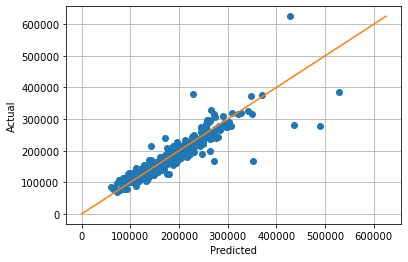

In [18]:
yhat = yscal.inverse_transform(yhat1)

yline = np.array([0, np.max(yts)])
plt.plot(yhat, yts, 'o')
plt.plot(yline, yline)
plt.grid()
plt.xlabel('Predicted')
plt.ylabel('Actual')



To understand which variables are important, we may find the variables with the largest coefficients.  We see that the among the top 10 coefficients, attributes such as square footage (SF) and quality dominate.

In [19]:
coeff_ls = reg_ls.coef_.ravel()
nprint = 10
I = np.argsort(np.abs(coeff_ls))
I = np.flipud(I)
for i in range(nprint):
    j = I[i]
    print('%20s %f' % (xnames[j], coeff_ls[j]) )

 Exterior1st_CemntBd 0.265422
         MSZoning_RL 0.259826
           GrLivArea 0.238964
 Exterior2nd_CmentBd -0.231779
         MSZoning_RM 0.216605
      KitchenQual_TA -0.214658
      KitchenQual_Gd -0.197348
            2ndFlrSF 0.171502
           YearBuilt 0.167901
        ExterQual_TA -0.139696


We can also try to find the variables that do not matter.  But, this is harder since it appears that most coefficients are non-zero. We can see this from both the stem plot (left) and the sorted coefficients (right).  It is hard to discard any coefficients.

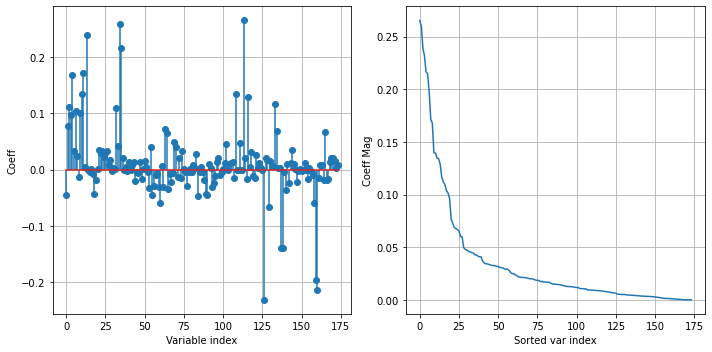

In [31]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.stem(coeff_ls, use_line_collection=True)
plt.xlabel('Variable index')
plt.ylabel('Coeff')
plt.grid()


plt.subplot(1,2,2)
coeff_sort_ls = np.flipud(np.sort(np.abs(coeff_ls)))
plt.plot(coeff_sort_ls)
plt.xlabel('Sorted var index')
plt.ylabel('Coeff Mag')
plt.grid()
plt.tight_layout()



*In-class exercise*:  Re-train the model with the variables with the largest 50 values in `coeff_ls`.  What is the test R^2?

In [34]:
# TODO
# reg_ls = LinearRegression()
reg_ls.fit(Xtr1[:,I[:50]], ytr1)
yhat1 = reg_ls.predict(Xts1[:,I[:50]])
rsq = r2_score(yts1, yhat1)
print('Test R^2     = %f' % rsq)

Test R^2     = 0.793943


## Lasso Regression

One method to perform the feature selection is called *Lasso* regression where you minimize an objective of the form:

     betahat = argmin (1/2/n)*\| y - A.dot(beta) \|^2 + alpha * \| beta \|_1
     
The term `\| beta \|_1 = \sum_j |beta[j]|` is called the *regularizer* and the scaling `alpha` is the regularization level.  When `alpha=0` we get the regular least squares fit.  But, as we take higher values of `alpha` we force the fit to find more *sparse* solutions meaning solutions with larger number of terms with `beta[j]=0`.  

We can perform Lasso regression with the `Lasso` method in sklearn as follows.

In [35]:
from sklearn.linear_model import Lasso
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

# Select alpha
alpha = 3e-3

# Create Lasso object and fit on training data
reg = Lasso(alpha=alpha)
reg.fit(Xtr1, ytr1)

# Predict and score on test
yhat1 = reg.predict(Xts1)
rsq = r2_score(yts1, yhat1)

print('Test R^2= %f' % rsq)

Test R^2= 0.821074


We see we get a slightly higher R^2 value.  We can also plot the coefficients and we see we have many more small coefficients in comparison to the linear regression with minimal regularization that we did before.  This means the model is, in effect, using a smaller number of variables.

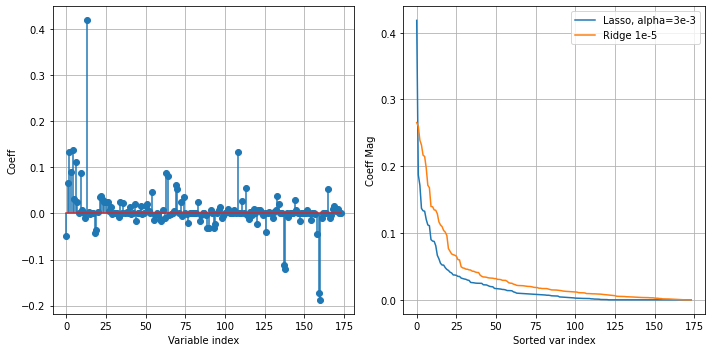

In [36]:
coeff_lasso = reg.coef_.ravel()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.stem(coeff_lasso, use_line_collection=True)
plt.xlabel('Variable index')
plt.ylabel('Coeff')
plt.grid()


plt.subplot(1,2,2)
coeff_sort_lasso = np.flipud(np.sort(np.abs(coeff_lasso)))
plt.plot(coeff_sort_lasso)
plt.plot(coeff_sort_ls)
plt.xlabel('Sorted var index')
plt.ylabel('Coeff Mag')
plt.grid()
plt.legend(['Lasso, alpha=3e-3', 'Ridge 1e-5'])
plt.tight_layout()

The value of `alpha` is typically selected via cross validation just as we did in model selection.  The following code performs cross validation with `nfold=10` folds.  For each fold, try a number of `alpha` values.

In [37]:
# Create cross-validation object
from sklearn.model_selection import KFold
nfold = 10
kf =KFold(nfold, shuffle=True)

# Alpha values to test
alphas = np.logspace(-6,-1,40)
nalpha = len(alphas)

# Run the cross-validation
rsq = np.zeros((nalpha, nfold))
for ifold, ind in enumerate(kf.split(X)):
        
    # Get the training data in the split
    Itr,Its = ind
    Xtr = X[Itr,:]
    ytr = y[Itr]
    Xts = X[Its,:]
    yts = y[Its]
    
    # Fit and transform the data
    Xtr1 = xscal.fit_transform(Xtr)
    Xts1 = xscal.transform(Xts)
    ytr1 = yscal.fit_transform(ytr[:,None])
    yts1 = yscal.transform(yts[:,None])

    for i, alpha in enumerate(alphas):

        # Fit on the training data
        reg = Lasso(alpha=alpha)
        reg.fit(Xtr1, ytr1)

        # Score on the test data
        yhat1 = reg.predict(Xts1)
        rsq[i, ifold] = r2_score(yts1, yhat1)
    
    print('Fold = %d' % ifold)
    
# Compute mean and SE
rsq_lasso_mean = np.mean(rsq, axis=1)
rsq_lasso_se  = np.std(rsq, axis=1) / np.sqrt(nfold-1)

Fold = 0
Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
Fold = 6
Fold = 7
Fold = 8
Fold = 9


We can then plot the mean and SE as a function of alpha.  

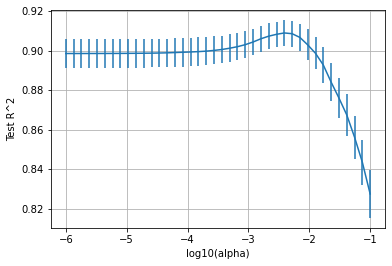

In [38]:
plt.errorbar(np.log10(alphas), rsq_lasso_mean, yerr=rsq_lasso_se)
plt.xlabel('log10(alpha)')
plt.ylabel('Test R^2')
plt.grid()
plt.show()

We see that there is an alpha value that maximizes the R^2. Below this value we overfit and above this we overfit. The code below selects the alpha using the normal rule (maximum mean test R^2).

In [39]:
im = np.argmax(rsq_lasso_mean)
alpha_normal = alphas[im]
print('Alpha optimal (normal rule) = %12.4e' % alpha_normal)
print('Mean test R^2 (normal rule) = %7.3f' % rsq_lasso_mean[im])


Alpha optimal (normal rule) =   3.8882e-03
Mean test R^2 (normal rule) =   0.909


We can then retrain the model at this value of alpha and plots the coefficients.  In comparison to Ridge regression with minimal regularization, we have many coefficients that are zero.

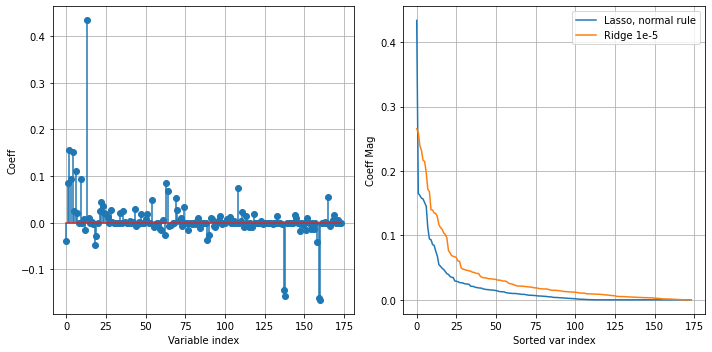

In [40]:
# Fit on the entire data
reg = Lasso(alpha=alpha_normal)
reg.fit(Xtr1, ytr1)

# Plot the normalized coefficients
coeff_lasso_norm = reg.coef_.ravel()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.stem(coeff_lasso_norm, use_line_collection=True)
plt.xlabel('Variable index')
plt.ylabel('Coeff')
plt.grid()


plt.subplot(1,2,2)
coeff_sort_norm = np.flipud(np.sort(np.abs(coeff_lasso_norm)))
plt.plot(coeff_sort_norm)
plt.plot(coeff_sort_ls)
plt.xlabel('Sorted var index')
plt.ylabel('Coeff Mag')
plt.grid()
plt.legend(['Lasso, normal rule', 'Ridge 1e-5'])
plt.tight_layout()

We can get an even more sparse solution using the one SE rule where we select the maximum alpha that achieves the maximum R^2 within one SE.

In [41]:
# Target R^2
im = np.argmax(rsq_lasso_mean)
rsq_tgt = rsq_lasso_mean[im] - rsq_lasso_se[im]

# Find the least complex model with R^2 > rsq_tgt
I = np.where(rsq_lasso_mean >= rsq_tgt)[0]
iopt = I[-1]
alpha_onese = alphas[iopt]

print('Alpha optimal (one SE rule) = %12.4e' % alpha_onese)
print('Mean test R^2 (one SE rule) = %7.3f' % rsq_lasso_mean[iopt])

Alpha optimal (one SE rule) =   9.4267e-03
Mean test R^2 (one SE rule) =   0.903


We can now plot the coefficients for the one SE rule.  We see that the coefficients are slightly more sparse than the normal rule. 

Optimal alpha = 0.009427


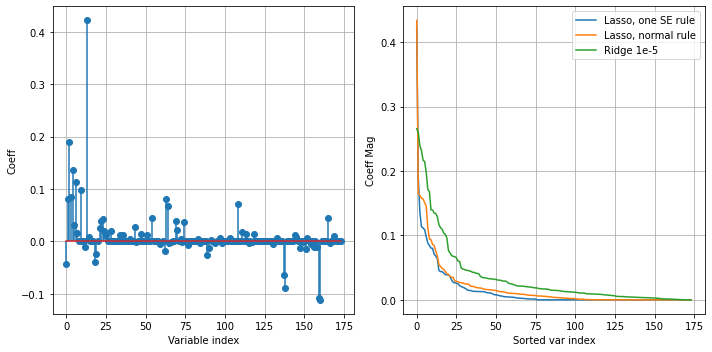

In [42]:



# Fit on the entire data
reg = Lasso(alpha=alpha_onese)
reg.fit(Xtr1, ytr1)

# Plot the normalized coefficients
coeff_lasso_onese = reg.coef_.ravel()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.stem(coeff_lasso_onese, use_line_collection=True)
plt.xlabel('Variable index')
plt.ylabel('Coeff')
plt.grid()


plt.subplot(1,2,2)
coeff_sort_onese = np.flipud(np.sort(np.abs(coeff_lasso_onese)))
plt.plot(coeff_sort_onese)
plt.plot(coeff_sort_norm)
plt.plot(coeff_sort_ls)
plt.xlabel('Sorted var index')
plt.ylabel('Coeff Mag')
plt.grid()
plt.legend(['Lasso, one SE rule', 'Lasso, normal rule', 'Ridge 1e-5'])
plt.tight_layout()

print("Optimal alpha = %f" % alpha_onese)

It is useful to print the variable names of the top 10 coefficients for the original Ridge regression model and the Lasso model with one SE rule.  We see that two area variables (`GrLivArea` and `2ndFlrSF`) have been replaced by one `GrLivArea` with more weight.

In [43]:
Ils = np.argsort(np.abs(coeff_ls))
Ils = np.flipud(Ils)

Ilasso = np.argsort(np.abs(coeff_lasso_onese))
Ilasso = np.flipud(Ilasso)

nprint = 10
print('Ridge                        | Lasso')
print('-----------------------------|--------------------------------')
for i in range(nprint):
    jls = Ils[i]
    jlasso = Ilasso[i]
    print('%20s %7.2f |  %20s %7.2f' % (xnames[jls], coeff_ls[jls], xnames[jlasso], coeff_lasso_onese[jlasso]) )

Ridge                        | Lasso
-----------------------------|--------------------------------
 Exterior1st_CemntBd    0.27 |             GrLivArea    0.42
         MSZoning_RL    0.26 |           OverallQual    0.19
           GrLivArea    0.24 |             YearBuilt    0.14
 Exterior2nd_CmentBd   -0.23 |            BsmtFinSF1    0.11
         MSZoning_RM    0.22 |        KitchenQual_TA   -0.11
      KitchenQual_TA   -0.21 |        KitchenQual_Gd   -0.11
      KitchenQual_Gd   -0.20 |           TotalBsmtSF    0.10
            2ndFlrSF    0.17 |          ExterQual_TA   -0.09
           YearBuilt    0.17 |           OverallCond    0.08
        ExterQual_TA   -0.14 |               LotArea    0.08


## Ridge Regression

An alternate form of regularization is Ridge regression where you select the coefficients with the rule:

     betahat = argmin (1/2/n)*\| y - A.dot(beta) \|^2 + alpha * \| beta \|_2^2
     
The optimization is similar to Lasso except the regularizer uses the two-norm squared, `\| beta \|_2^2` instead of the one-norm, `\| beta \|_1`.  This regularizer tends to make coefficients smaller, but not necessarily zero.  

We already used Ridge regression above with a small value of alpha for improving the conditioning of the fit.  Here, we can try to optimally select `alpha` with cross-validation.

In [44]:
# Create cross-validation object
from sklearn.model_selection import KFold
nfold = 10
kf =KFold(nfold, shuffle=True)

# Alpha values to test
alphas_ridge = np.logspace(-3,3,40)
nalpha = len(alphas)

# Run the cross-validation
rsq = np.zeros((nalpha, nfold))
for ifold, ind in enumerate(kf.split(X)):
        
    # Get the training data in the split
    Itr,Its = ind
    Xtr = X[Itr,:]
    ytr = y[Itr]
    Xts = X[Its,:]
    yts = y[Its]
    
    # Fit and transform the data
    Xtr1 = xscal.fit_transform(Xtr)
    Xts1 = xscal.transform(Xts)
    ytr1 = yscal.fit_transform(ytr[:,None])
    yts1 = yscal.transform(yts[:,None])

    for i, alpha in enumerate(alphas_ridge):

        # Fit on the training data
        reg = Ridge(alpha=alpha)
        reg.fit(Xtr1, ytr1)

        # Score on the test data
        yhat1 = reg.predict(Xts1)
        rsq[i, ifold] = r2_score(yts1, yhat1)
    
    print('Fold = %d' % ifold)
    
# Compute mean and SE
rsq_ridge_mean = np.mean(rsq, axis=1)
rsq_ridge_se  = np.std(rsq, axis=1) / np.sqrt(nfold-1)


Fold = 0
Fold = 1
Fold = 2
Fold = 3
Fold = 4
Fold = 5
Fold = 6
Fold = 7
Fold = 8
Fold = 9


We can plot the test R^2 value as a function of the alpha values.  We see that the optimal R^2 is slightly higher for Lasso.

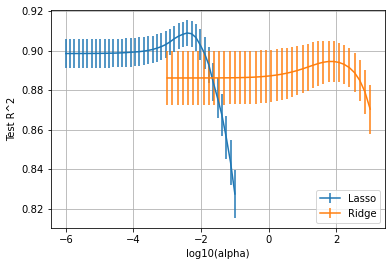

Optimal R^2 Lasso:  0.908953
Optimal R^2 Ridge:  0.894531


In [45]:
plt.errorbar(np.log10(alphas), rsq_lasso_mean, yerr=rsq_lasso_se)
plt.errorbar(np.log10(alphas_ridge), rsq_ridge_mean, yerr=rsq_ridge_se)
plt.xlabel('log10(alpha)')
plt.ylabel('Test R^2')
plt.grid()
plt.legend(['Lasso', 'Ridge'], loc='lower right')
plt.show()

print('Optimal R^2 Lasso:  %f' % np.max(rsq_lasso_mean))
print('Optimal R^2 Ridge:  %f' % np.max(rsq_ridge_mean))

## LASSO path

To further illustrate the effect of regularization, we conclude by drawing the *LASSO path*.  This is simply a plot of the coefficients as a function of the regularization `alpha`.  We do not need to do this for the analysis, but the path demonstrates the effect of regularization well. 


In [46]:
import sklearn.linear_model

X1 = xscal.fit_transform(X)
y1 = xscal.fit_transform(y[:,None])

alphas_path = np.logspace(-5,1,40)
alphas1, coeffs, _ = sklearn.linear_model.lasso_path(X1, y1, alphas=alphas_path)

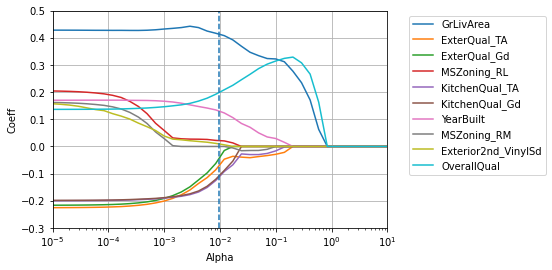

In [47]:
nplot = 10
I = np.argsort(np.abs(coeffs[0,:,-1]))
I = np.flipud(I)
I = I[:nplot]

# Plot the paths of the coefficients
coeff_top = coeffs[0,I,:].T
plt.semilogx(alphas1,coeff_top)
plt.plot(alpha_onese*np.array([1,1]), [-0.3,0.5], '--')
plt.grid()
plt.legend(xnames[I], bbox_to_anchor=(1.05, 1))
plt.xlabel('Alpha')
plt.ylabel('Coeff')
plt.xlim([1e-5, 10])
_ = plt.ylim([-0.3, 0.5])

We see that when alpha is selected very high, all the coefficients are zero.  As alpha is reduced, more coefficients become active starting with overall living area (`GrLivArea`) and the overall quality (`Overall quality`).